In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from pointprocess import *
import pointprocess.plotting as pplot
from lightning_setup import *
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
c = Region(city=cities['cedar'])
c.SUBSETTED = False
c.CENTER = (37.7, -111.8)
c.RADIUS = 0.7
c.define_grid(step=1, units='km')

xx, yy = np.meshgrid(c.gridx[1:], c.gridy[1:])
xx = xx.flatten()
yy = yy.flatten()
X = np.stack([yy, xx])

In [3]:
storm = '2011-08-21'

In [4]:
from titan import *
fname = './input/{storm}.txt'.format(storm=storm)
titan_df = read_TITAN(fname)

In [5]:
tr = titan_df.index.unique().sort_values()
tr = tr.insert(0, tr[0]-pd.Timedelta(minutes=3))

In [6]:
ds = c.get_daily_ds(storm, filter_CG=dict(method='CG'))

In [7]:
# slice according to the titan times
box, tr = c.get_grid_slices(ds, tr=tr)
tr = tr[1:]

In [8]:
print('The shape of the data is in the order t, x, y', box.shape)

The shape of the data is in the order t, x, y (102, 100, 124)


In [9]:
def Equation_19(box):
    # total number of time periods
    n1 = box.shape[0]

    # total number of grids
    n2 = box.shape[1] * box.shape[2]

    # sum of counts over all the grid cells divided by n2
    A = box.sum(axis=(1,2))/n2

    # sum of counts over all the timesteps divided by n1
    B = box.sum(axis=0).flatten()/n1

    # 1 over sum of counts divided by n1 and n2
    C = 1/(box.sum()/n1/n2)

    # control lambda of k, l
    lambda_k_l = np.outer(A, B)*C
    
    return lambda_k_l

def Equation_18(box):
    lambda_k_l = Equation_19(box)
    return ((box - lambda_k_l.reshape(box.shape))**2).sum()

In [10]:
%%time
Equation_18(box)

CPU times: user 5.22 ms, sys: 13 ms, total: 18.2 ms
Wall time: 17.7 ms


801.22501282631652

In [11]:
mini_df = titan_df[['EnvelopeArea(km2)', 'ReflCentroidLat(deg)', 'ReflCentroidLon(deg)', 'MaxDBZ(dBZ)', 'SimpleNum']]
mini_df.columns = ['Ai', 'lat', 'lon', 'Zi', 'i']

In [12]:
def get_loc(ll, grid_ll):
    if ll<grid_ll[-1] and ll>grid_ll[0]:
        return np.argmax(grid_ll>ll)
    else:
        return np.nan

def get_l(x, grid_lat, grid_lon):
    '''
    Given a latlon position, return the 1D and 2D index
    of the corresponding grid cell. Also works on series
    of positions
    
    Parameters
    ----------
    x: (lat, lon) where lat, lon are floats or series
    grid_lat: list of the lat edges of the y grid cells
    grid_lon: list of the lon edges of the x grid cells    
    
    Returns
    -------
    yloc, xloc, l: tuple of integers or tuple of series
    
    Examples
    --------
    # for one position
    get_l((df.lat[0], df.lon[0]), c.gridy, c.gridx)
    
    df.assign(**dict(list(zip(['yloc', 'xloc', 'l'], 
                              get_l((df.lat, df.lon), 
                                    c.gridy, c.gridx)
    '''
    lat, lon = x
    if hasattr(lat, '__iter__'):
        yloc = lat.apply(get_loc, grid_ll=grid_lat)
        xloc = lon.apply(get_loc, grid_ll=grid_lon)
    else:
        yloc = get_loc(lat, grid_lat)
        xloc = get_loc(lon, grid_lon)
    l = (yloc-1)*(grid_lon.shape[0]-1)+(xloc-1)
    return yloc, xloc, l

In [13]:
%%time
s = get_l((mini_df['lat'], mini_df['lon']), c.gridy, c.gridx)
mini_df = mini_df.assign(**dict(list(zip(['yloc', 'xloc', 'l'], s))))

CPU times: user 2.66 ms, sys: 4.11 ms, total: 6.76 ms
Wall time: 5.3 ms


In [188]:
from geopy.distance import vincenty, great_circle

In [204]:
def Equation_11(x, Yi, sigmai, Ii):
    g = Ii/(sigmai*(2*np.pi)**.5) * np.exp(-.5*(great_circle(Yi, x).km**2)/sigmai**2)
    return g

def Equation_12(Ai, gamma):
    sigmai = gamma * (Ai/np.pi)**.5
    return sigmai

def Equation_13(Zi, alpha, beta):
    Ii = alpha*(Zi-beta)
    return Ii

In [212]:
def at_t(t, dfi, gamma, alpha, beta):
    '''
    This function is the powerhouse so anything we can 
    do to quicken things up with pay dividends later on
    
    Parameters
    ----------
    t: time at which there is a storm element
    dfi: dataframe for just the storm
    
    Return
    ------
    g: np.array of shape nl
    '''
    # 1.69 ms
    d = dfi.loc[t,:].to_dict()

    sigmai = Equation_12(d['Ai'], gamma)
    Ii = Equation_13(d['Zi'], alpha, beta)

    g = []
    ncols = c.gridx.shape[0]-1
    for iy, y in enumerate(c.gridy[1:]):
        if iy<(d['yloc']-sigmai*2) or iy>(d['yloc']+sigmai*2):
            g.extend([0]*ncols)
            continue
        for ix, x in enumerate(c.gridx[1:]):
            if ix<(d['xloc']-sigmai*2) or ix>(d['xloc']+sigmai*2):
                g.append(0)
                continue
            g.append(Equation_11((y,x), Yi=(d['lat'],d['lon']), sigmai=sigmai, Ii=Ii))
    return np.array(g)

In [213]:
def Equation_16(mini_df, gamma=1, alpha=0, beta=45):
    '''
    Benchmarking: 2.54 s for nl=12400, nk=102, ni=89
    '''
    gamma_at_t = []
    for i, dfi in mini_df.groupby('i'):
        gamma_at_t.extend([at_t(t, dfi, gamma, alpha, beta) for t in dfi.index])
    gamma_at_t = np.stack(gamma_at_t)

    bar = pd.DataFrame(gamma_at_t, index=titan_df.index)
    bar = bar.sort_index()

    d = {}
    for t in tr:
        d.update({t:bar[bar.index==t].sum()})
    gamma_kl = pd.DataFrame(d).T

    return gamma_kl.values.reshape(box.shape)

In [214]:
def Equation_17(N_kl, gamma_kl):
    '''
    Benchmarking: 5.41 ms
    '''
    L = ((np.subtract(N_kl, gamma_kl))**2).sum()
    return L

In [217]:
strikes_per_dbz_45 = box.sum()/(mini_df.Ai*(mini_df.Zi-45)).sum()
strikes_per_dbz_45

0.010726273253822506

In [218]:
%%time
import scipy.optimize as optimize

def f(c):
    gamma_kl = Equation_16(mini_df, gamma=c[0], alpha=c[1], beta=c[2])
    return Equation_17(box, gamma_kl)
result = optimize.minimize(f, [1, strikes_per_dbz_45, 45], tol=10)
print(result)

      fun: 821.2474685254509
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-0.62825775, -0.35668945,  0.07924652])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([  1.00002479e+00,   1.31060173e-02,   4.49999945e+01])
CPU times: user 38.6 s, sys: 1.26 s, total: 39.9 s
Wall time: 39.9 s


In [ ]:
%%time
import scipy.optimize as optimize

def f(c):
    gamma_kl = Equation_16(mini_df, gamma=c[0], alpha=c[1], beta=c[2])
    return Equation_17(box, gamma_kl)
result = optimize.minimize(f, [1, strikes_per_dbz_45, 45], tol=5)
print(result)

### Unused

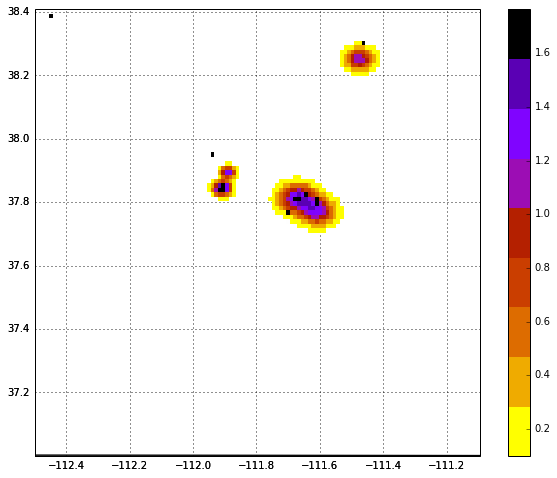

In [252]:
plt.figure(figsize=(10,8))
c.plot_grid(gamma_kl.values.reshape(box.shape)[50], cmap=cmap, cbar=True, vmin=.1)
c.plot_grid(box[50], cmap=cmap, cbar=False, vmin=.1);

In [141]:
def at_t(t, dfi, gamma=1, alpha=0, beta=1):
    # Benchmarking: 839 µs
    Yi = (dfi.loc[t,'lat'], dfi.loc[t, 'lon'])
    Ai = dfi.loc[t, 'Ai']
    Zi = dfi.loc[t, 'Zi']
    xloc = dfi.loc[t, 'x']
    yloc = dfi.loc[t, 'y']

    sigmai = Equation_12(Ai, gamma)
    Ii = Equation_13(Zi-45, alpha, beta)
    
    # Benchmarking: 103 µs
    xx, yy = np.meshgrid(c.gridx[max(0, int(xloc-Ai)): min(int(xloc+Ai), c.gridx.shape[0])],
                         c.gridy[max(0, int(yloc-Ai)): min(int(yloc+Ai), c.gridy.shape[0])])
    X = np.stack([yy.flatten(), xx.flatten()])

    # Benchmarking: 3.7 ms
    g = np.apply_along_axis(Equation_11, 0, X, Yi=Yi, sigmai=sigmai, Ii=Ii)
    
    #TODO but then we have a mis-shapen g_t
    return g

In [120]:
def at_t(t, dfi, gamma=1, alpha=0, beta=1):
    # Benchmarking: 839 µs per t
    Yi = (dfi.loc[t,'lat'], dfi.loc[t, 'lon'])
    sigmai = Equation_12(dfi.loc[t, 'Ai'], gamma)
    Ii = Equation_13(dfi.loc[t, 'Zi']-45, alpha, beta)

    # Benchmarking: 465 ms per t
    g = np.apply_along_axis(Equation_11, 0, X, Yi=Yi, sigmai=sigmai, Ii=Ii)
    return g

In [98]:
%%time
get_l((mini_df.lat[0], mini_df.lon[0]), c.gridy, c.gridx)

CPU times: user 284 µs, sys: 7 µs, total: 291 µs
Wall time: 273 µs


(86, 90, 10629)

In [53]:
mini_df.lat[0], mini_df.lon[0]

38.205399999999997

In [48]:
box.shape[2]

124

In [49]:
c.gridx.shape

(125,)

In [45]:
%%time
# if lat, lon are within bounds, get the grid cell they fall in.
def get_loc(ll, grid_ll):
    if x<grid_ll[-1] and x>grid_ll[0]:
        return np.argmax(grid_ll>x)
    else:
        return None
    
mini_df = mini_df.assign(x=mini_df.lon.apply(func, grid_lon=c.gridx),
                         y=mini_df.lat.apply(func, grid_lon=c.gridy))

CPU times: user 4.75 ms, sys: 2.98 ms, total: 7.73 ms
Wall time: 97.5 ms


In [46]:
mini_df = mini_df.assign(l=((mini_df.y-1)*(box.shape[2])+(mini_df.x)-1))
mini_df.head()

,Ai,lat,lon,Zi,i,x,y,l
date_time,,,,,,,,
2011-08-21 18:10:20,4,38.2054,-111.485,48.4944,1,90.0,86.0,10629.0
2011-08-21 18:13:28,6,38.2083,-111.477,47.4992,1,91.0,86.0,10630.0
2011-08-21 18:16:37,7,38.2125,-111.477,50.6413,1,91.0,87.0,10754.0
2011-08-21 18:19:58,6,38.2181,-111.474,48.9443,1,91.0,87.0,10754.0
2011-08-21 18:23:06,2,38.2243,-111.471,46.5974,1,91.0,87.0,10754.0


In [ ]:
def get_l(x):
    